# About the notebook

In [32]:
### import libraries
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(MPSK)))
suppressMessages(suppressWarnings(library(tsne)))

suppressMessages(suppressWarnings(library(flowCore)))
suppressMessages(suppressWarnings(library(flowStats)))
suppressMessages(suppressWarnings(library(flowViz)))
suppressMessages(suppressWarnings(library(flowMatch)))
suppressMessages(suppressWarnings(library(flowMap)))

suppressMessages(suppressWarnings(library(igraph)))
suppressMessages(suppressWarnings(library(pheatmap)))
suppressMessages(suppressWarnings(library(RColorBrewer)))


### set directories
dat_dir = "/data/clintko/SMPK"

# Import data

previous code

```
%%Python
target_dir = "/data/SMPK"
with open(os.path.join(target_dir, "res0_GEN070XT_CMVpp65.pic"), 'rb') as f:
    res = pickle.load(f)

%%R -i res
resRelab      = relabelChain(res)
resCalibrated = calibrate(resRelab)
chainSummary  = summarizeChain(resRelab)
```

import results from MPSK

In [3]:
dat_mpsk_raw  = read_delim(file.path(dat_dir, "ep8cs_dat_mpsk_raw.txt"),  delim = "\t")
dat_mpsk_cal  = read_delim(file.path(dat_dir, "ep8cs_dat_mpsk_cal.txt"),  delim = "\t")
dat_gaussnorm = read_delim(file.path(dat_dir, "ep8cs_dat_gaussnorm.txt"), delim = "\t")

Parsed with column specification:
cols(
  sample = col_character(),
  cluster = col_integer(),
  `FSC-A` = col_double(),
  `SSC-A` = col_double(),
  Aqua = col_double(),
  CD3 = col_double(),
  CD4 = col_double(),
  CD8 = col_double(),
  TNFa = col_double(),
  IL2 = col_double(),
  IFNg = col_double(),
  CD107a = col_double()
)
Parsed with column specification:
cols(
  sample = col_character(),
  cluster = col_integer(),
  `FSC-A` = col_double(),
  `SSC-A` = col_double(),
  Aqua = col_double(),
  CD3 = col_double(),
  CD4 = col_double(),
  CD8 = col_double(),
  TNFa = col_double(),
  IL2 = col_double(),
  IFNg = col_double(),
  CD107a = col_double()
)
Parsed with column specification:
cols(
  sample = col_character(),
  `FSC-A` = col_double(),
  `SSC-A` = col_double(),
  Aqua = col_double(),
  CD3 = col_double(),
  CD4 = col_double(),
  CD8 = col_double(),
  TNFa = col_double(),
  IL2 = col_double(),
  IFNg = col_double(),
  CD107a = col_double()
)


In [4]:
dim(dat_mpsk_raw)
dim(dat_mpsk_cal)
dim(dat_gaussnorm)

[1] 180000     12

[1] 180000     12

[1] 180000     11

# Mapping Labels using FlowMatch

### rename clusters for applying the flowMatch methods on cluster id and data

rename the clusters label on our dataframe

In [10]:
cat("\n=====================\n")
dat = dat_mpsk_raw
set.seed(10); dat %>% dplyr::select(sample, cluster) %>% dplyr::sample_n(size = 5) %>% print
dat$cluster %>% unique %>% print

### map 10 to 5 and 9 to 7
### so that the cluster labels continuous from 1 to 7
dat$cluster = dat$cluster %>% 
    as.character %>% 
    recode(., "10" = "5", "9" = "7") %>%
    as.integer

cat("\n=====================\n")
dat_mpsk2_raw = dat
set.seed(10); dat %>% dplyr::select(sample, cluster) %>% dplyr::sample_n(size = 5) %>% print
dat$cluster %>% unique %>% print


# A tibble: 5 x 2
  sample cluster
  <chr>    <int>
1 10           9
2 06           6
3 08           9
4 13          10
5 02           8
[1]  4  3  1  8  9  2 10  6  7

# A tibble: 5 x 2
  sample cluster
  <chr>    <int>
1 10           7
2 06           6
3 08           7
4 13           5
5 02           8
[1] 4 3 1 8 7 2 5 6


do the same thing to the mpsk calibrated data

In [11]:
### intialize
dat = dat_mpsk_cal

### map 10 to 5 and 9 to 7
### so that the cluster labels continuous from 1 to 7
dat$cluster = dat$cluster %>% 
    as.character %>% 
    recode(., "10" = "5", "9" = "7") %>%
    as.integer

### assign the output
dat_mpsk2_cal = dat

### test flowMatch on raw data

take a look at our data

In [12]:
head(dat_mpsk2_raw, 3)

sample,cluster,FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
01,4,-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.2734487,0.60710339
01,3,-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.3496486,-0.03757027
01,1,0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.4259069,-0.02672243


example to compare clusters between two samples

In [13]:
create_cluster_sample = function(dat, idx_sample) {
    # helper function to create clusteredSample object
    ############################################
    ### subset data by index of sample
    dat_sub  = dat %>% dplyr::filter(sample == idx_sample) 
    
    ### get the data frame and cluster
    mat      = dat_sub %>% dplyr::select(-sample, -cluster)
    clust    = dat_sub$cluster
    
    ### create ClusteredSample and return
    res = ClusteredSample(labels = clust, sample = mat)
    return(res)

} # end func

### set referece -> cluster == 1 
clustRef = create_cluster_sample(dat_mpsk2_raw, "01")
clustSam = create_cluster_sample(dat_mpsk2_raw, "02")

mec = match.clusters(clustRef, clustSam, dist.type="Mahalanobis", unmatch.penalty=99999)
summary(mec)

clusters/meta-clusters      matched clusters/meta-clusters
from sample1/template1      sample2/template2 
           1                            1
           2                            2
           3                            3
           4                            4
           5                            5
           6                            6
           7                            7
           8                            8


### apply flowMatch on raw data 

In [14]:
### initialization
idxs = str_pad(1:18, 2, pad = "0")
dat  = dat_mpsk2_raw

### set reference
clustRef = create_cluster_sample(dat, "01")

### loop through all samples / labs
lst_mec = lapply(idxs, function(idx){
    ### create clustered sample
    clustSam = create_cluster_sample(dat, idx)
    
    ### match clusters
    mec = match.clusters(
        clustRef, 
        clustSam,
        dist.type="Mahalanobis", 
        unmatch.penalty=99999)
 
    return(mec)
}) # end lapply

res = lapply(lst_mec, function(x){x@match21 %>% unlist})
res = do.call(rbind, res)
rownames(res) = paste("Sample", idxs)
colnames(res) = paste("Cluster", 1:ncol(res))
res

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
Sample 01,1,2,3,4,5,6,7,8
Sample 02,1,2,3,4,5,6,7,8
Sample 03,1,2,3,4,5,6,7,8
Sample 04,1,2,3,4,5,6,7,8
Sample 05,1,2,3,4,5,6,7,8
Sample 06,1,2,3,4,5,6,7,8
Sample 07,1,2,3,4,5,6,7,8
Sample 08,6,2,3,5,4,1,7,8
Sample 09,1,2,3,4,5,6,7,8
Sample 10,1,2,3,4,5,6,7,8


### apply flowMatch on calibrated data

In [15]:
### initialization
idxs = str_pad(1:18, 2, pad = "0")
dat  = dat_mpsk2_cal

### set reference
clustRef = create_cluster_sample(dat, "01")

### loop through all samples / labs
lst_mec = lapply(idxs, function(idx){
    ### create clustered sample
    clustSam = create_cluster_sample(dat, idx)
    
    ### match clusters
    mec = match.clusters(
        clustRef, 
        clustSam,
        dist.type="Mahalanobis", 
        unmatch.penalty=99999)
 
    return(mec)
}) # end lapply

res = lapply(lst_mec, function(x){x@match21 %>% unlist})
res = do.call(rbind, res)
rownames(res) = paste("Sample", idxs)
colnames(res) = paste("Cluster", 1:ncol(res))
res

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
Sample 01,1,2,3,4,5,6,7,8
Sample 02,1,2,3,4,5,6,7,8
Sample 03,1,2,3,4,5,6,7,8
Sample 04,1,2,3,4,5,6,7,8
Sample 05,1,2,3,4,5,6,7,8
Sample 06,1,2,3,4,5,6,7,8
Sample 07,1,2,3,4,5,6,7,8
Sample 08,1,2,3,4,5,6,7,8
Sample 09,1,2,3,4,5,6,7,8
Sample 10,1,2,3,4,5,6,7,8


# Mapping Labels using FlowMap

In [18]:
head(dat_mpsk_raw)

sample,cluster,FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
01,4,-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.27344867,0.60710339
01,3,-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.34964856,-0.03757027
01,1,0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.42590688,-0.02672243
01,4,-1.5681802,-0.57996979,-0.5588165,0.2319850,1.8415205,-0.1502302,-0.5595654,0.02146696,-0.51009832,-0.01391902
01,8,-1.5371229,0.32463843,-0.2535651,-0.6772130,2.0872188,-1.3166316,-0.6453749,-0.22168409,-0.88871667,0.15053694
01,1,-0.2959737,-0.29703637,-0.2005701,-0.6302307,0.4919176,-0.8454200,-0.2646515,2.44124150,0.02647195,0.33899091


In [23]:
sam1 = dat_mpsk_raw %>% dplyr::filter(sample == "01")
dim(sam1)
head(sam1)
unique(sam1$sample)

[1] 10000    12

sample,cluster,FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
01,4,-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.27344867,0.60710339
01,3,-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.34964856,-0.03757027
01,1,0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.42590688,-0.02672243
01,4,-1.5681802,-0.57996979,-0.5588165,0.2319850,1.8415205,-0.1502302,-0.5595654,0.02146696,-0.51009832,-0.01391902
01,8,-1.5371229,0.32463843,-0.2535651,-0.6772130,2.0872188,-1.3166316,-0.6453749,-0.22168409,-0.88871667,0.15053694
01,1,-0.2959737,-0.29703637,-0.2005701,-0.6302307,0.4919176,-0.8454200,-0.2646515,2.44124150,0.02647195,0.33899091


[1] "01"

In [116]:
dat  = dat_mpsk2_raw
dat  = dat %>% dplyr::select(-cluster) %>% dplyr::mutate(cluster = dat$cluster)

idx  = "01"
dat1_raw        = dat      %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample)
dat1_clust1_raw = dat1_raw %>% dplyr::filter(cluster == 1) 

idx  = "02"
dat2_raw        = dat      %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample)
dat2_clust1_raw = dat2_raw %>% dplyr::filter(cluster == 1) 

#####################################

dat  = dat_mpsk2_cal
dat  = dat %>% dplyr::select(-cluster) %>% dplyr::mutate(cluster = dat$cluster)

idx  = "01"
dat1_cal        = dat      %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample)
dat1_clust1_cal = dat1_cal %>% dplyr::filter(cluster == 1) 

idx  = "02"
dat2_cal        = dat      %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample)
dat2_clust1_cal = dat2_cal %>% dplyr::filter(cluster == 1)

Warning message in graph.adjacency(distmat * mstree, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”Warning message in graph.adjacency(distmat, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”

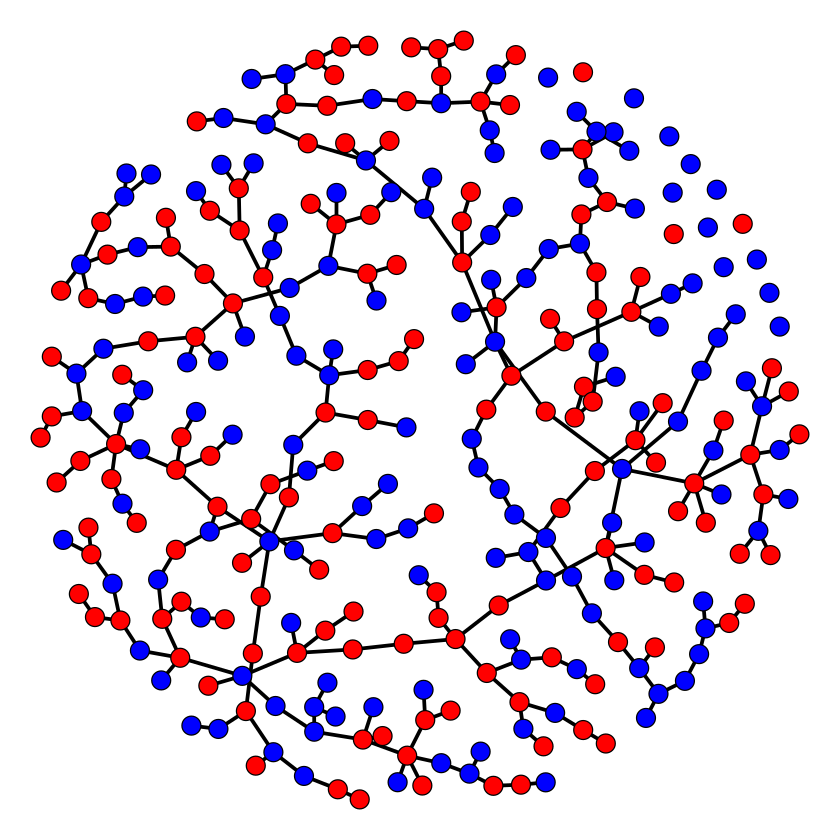

In [117]:
###
tmp1 = dat1_clust1_raw %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 1) %>% sample_frac(size = 0.1)
tmp2 = dat1_clust1_raw %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 2) %>% sample_frac(size = 0.1)
dat_sub = rbind(tmp1, tmp2)

###
set.seed(123)
g1 = makeFRMST(dat_sub)

###
par(mar=c(0,0,0,0))
plot(g1$g, 
     vertex.label.cex=0.01,
     layout=layout.fruchterman.reingold(g1$g))

Warning message in graph.adjacency(distmat * mstree, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”Warning message in graph.adjacency(distmat, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”

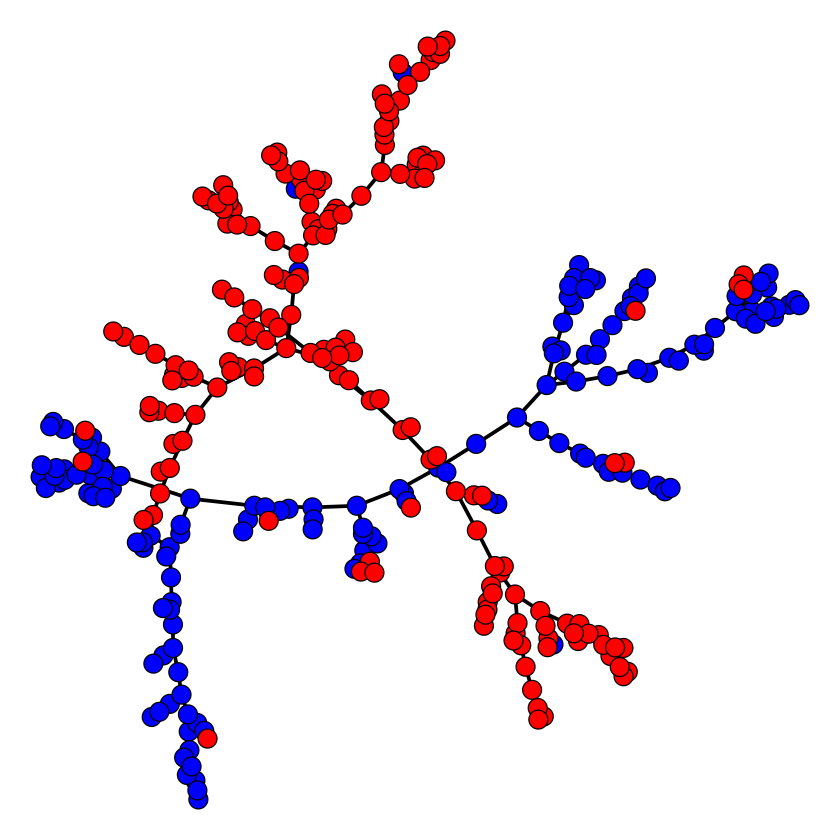

In [118]:
###
tmp1 = dat1_clust1_raw %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 1) %>% sample_frac(size = 0.1)
tmp2 = dat2_clust1_raw %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 2) %>% sample_frac(size = 0.1)
dat_sub = rbind(tmp1, tmp2)

###
set.seed(123)
g1 = makeFRMST(dat_sub)

###
par(mar=c(0,0,0,0))
plot(g1$g, 
     vertex.label.cex=0.01,
     layout=layout.fruchterman.reingold(g1$g))

Warning message in graph.adjacency(distmat * mstree, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”Warning message in graph.adjacency(distmat, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”

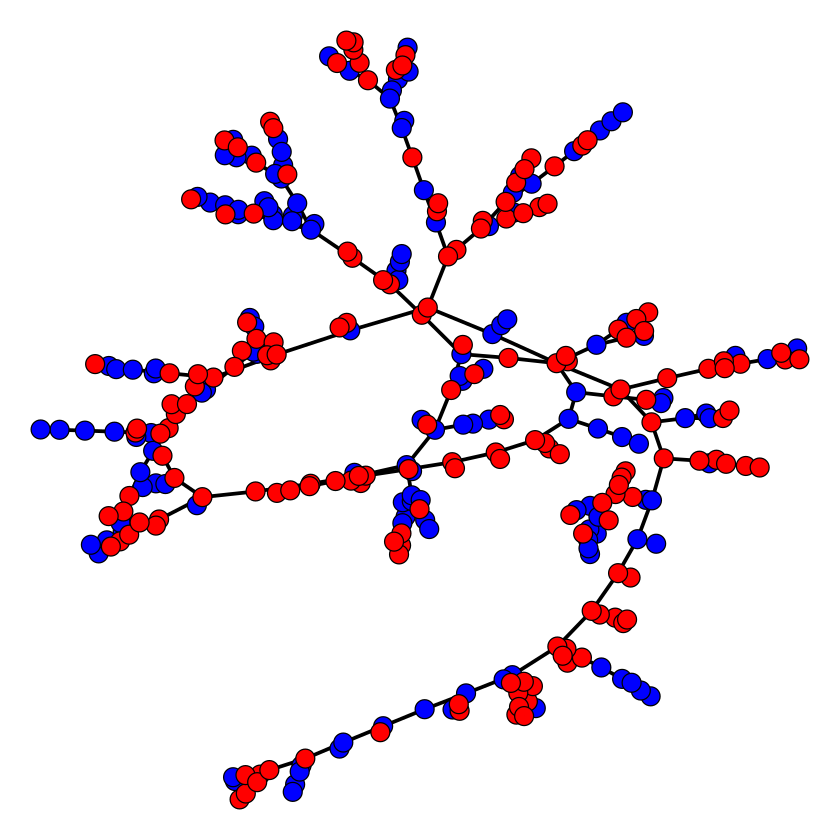

In [119]:
###
tmp1 = dat1_clust1_cal %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 1) %>% sample_frac(size = 0.1)
tmp2 = dat2_clust1_cal %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 2) %>% sample_frac(size = 0.1)
dat_sub = rbind(tmp1, tmp2)

###
set.seed(123)
g1 = makeFRMST(dat_sub)

###
par(mar=c(0,0,0,0))
plot(g1$g, 
     vertex.label.cex=0.01,
     layout=layout.fruchterman.reingold(g1$g))

In [122]:
tmp1 = dat1_raw
tmp2 = dat1_raw
c(table(tmp1$cluster), table(tmp2$cluster))

1    2    3    4    5    6    7    8    1    2    3    4    5    6    7    8 
1497 1509 2416 1590   97  277  511 2103 1497 1509 2416 1590   97  277  511 2103

In [128]:
dim(dat1_raw)
head(dat1_raw)
unique(dat1_raw$cluster)

[1] 10000    11

FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a,cluster
-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.27344867,0.60710339,4
-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.34964856,-0.03757027,3
0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.42590688,-0.02672243,1
-1.5681802,-0.57996979,-0.5588165,0.2319850,1.8415205,-0.1502302,-0.5595654,0.02146696,-0.51009832,-0.01391902,4
-1.5371229,0.32463843,-0.2535651,-0.6772130,2.0872188,-1.3166316,-0.6453749,-0.22168409,-0.88871667,0.15053694,8
-0.2959737,-0.29703637,-0.2005701,-0.6302307,0.4919176,-0.8454200,-0.2646515,2.44124150,0.02647195,0.33899091,1


[1] 4 3 1 8 7 2 5 6

In [130]:
tmp1 = dat1_raw
colnames(tmp1) = colnames(tmp1) %>% recode("cluster" = "id")
head(tmp1)

FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a,id
-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.27344867,0.60710339,4
-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.34964856,-0.03757027,3
0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.42590688,-0.02672243,1
-1.5681802,-0.57996979,-0.5588165,0.2319850,1.8415205,-0.1502302,-0.5595654,0.02146696,-0.51009832,-0.01391902,4
-1.5371229,0.32463843,-0.2535651,-0.6772130,2.0872188,-1.3166316,-0.6453749,-0.22168409,-0.88871667,0.15053694,8
-0.2959737,-0.29703637,-0.2005701,-0.6302307,0.4919176,-0.8454200,-0.2646515,2.44124150,0.02647195,0.33899091,1


In [131]:
tmp1 = dat1_raw
colnames(tmp1) = colnames(tmp1) %>% recode("cluster" = "id")

tmp2 = dat1_raw
colnames(tmp2) = colnames(tmp2) %>% recode("cluster" = "id")


res1 = getFRest(
    tmp1, tmp2,
    #sampleMethod="equalSize",
    sampleMethod="proportional",
    sampleSize=100,
    ndraws=100,
    estStat="median",
    ncores=NULL)

computing on 24 cores
computing FR statistics between sample ... 




Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



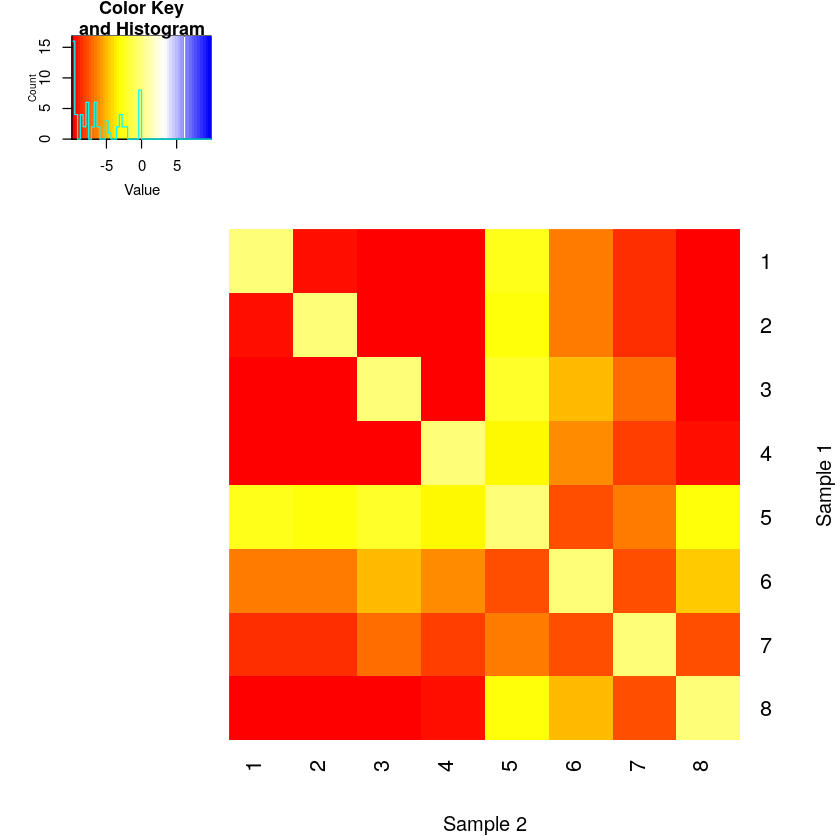

In [132]:
library(gplots)

par(mar=c(0,0,0,0))
heatmapCols <- colorRampPalette(c("red","yellow","white","blue"))(50)

heatmap.2(
    res1@ww,
    trace="none",
    col=heatmapCols,
    symm=FALSE,
    dendrogram="none",
    Rowv=FALSE,
    Colv=FALSE,
    xlab="Sample 2",
    ylab="Sample 1")

In [78]:
###
tmp1 = dat1_clust1_cal %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 1) %>% sample_frac(size = 0.1)
tmp2 = dat2_clust1_cal %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 2) %>% sample_frac(size = 0.1)
dat_sub = rbind(tmp1, tmp2)

###
set.seed(123)
g1 = makeFRMST(dat_sub)

###
par(mar=c(0,0,0,0))
plot(g1$g, 
     vertex.label.cex=0.01,
     layout=layout.fruchterman.reingold(g1$g))

Warning message:
“Unknown or uninitialised column: 'sam'.”

ERROR: Error in rep(1, Nevents[1]): invalid 'times' argument


In [ ]:
res1 = getFRest(
    sam1, sam2,
    sampleMethod="proportional",
    sampleSize=100,
    ndraws=100,
    estStat="median",
    ncores=NULL)

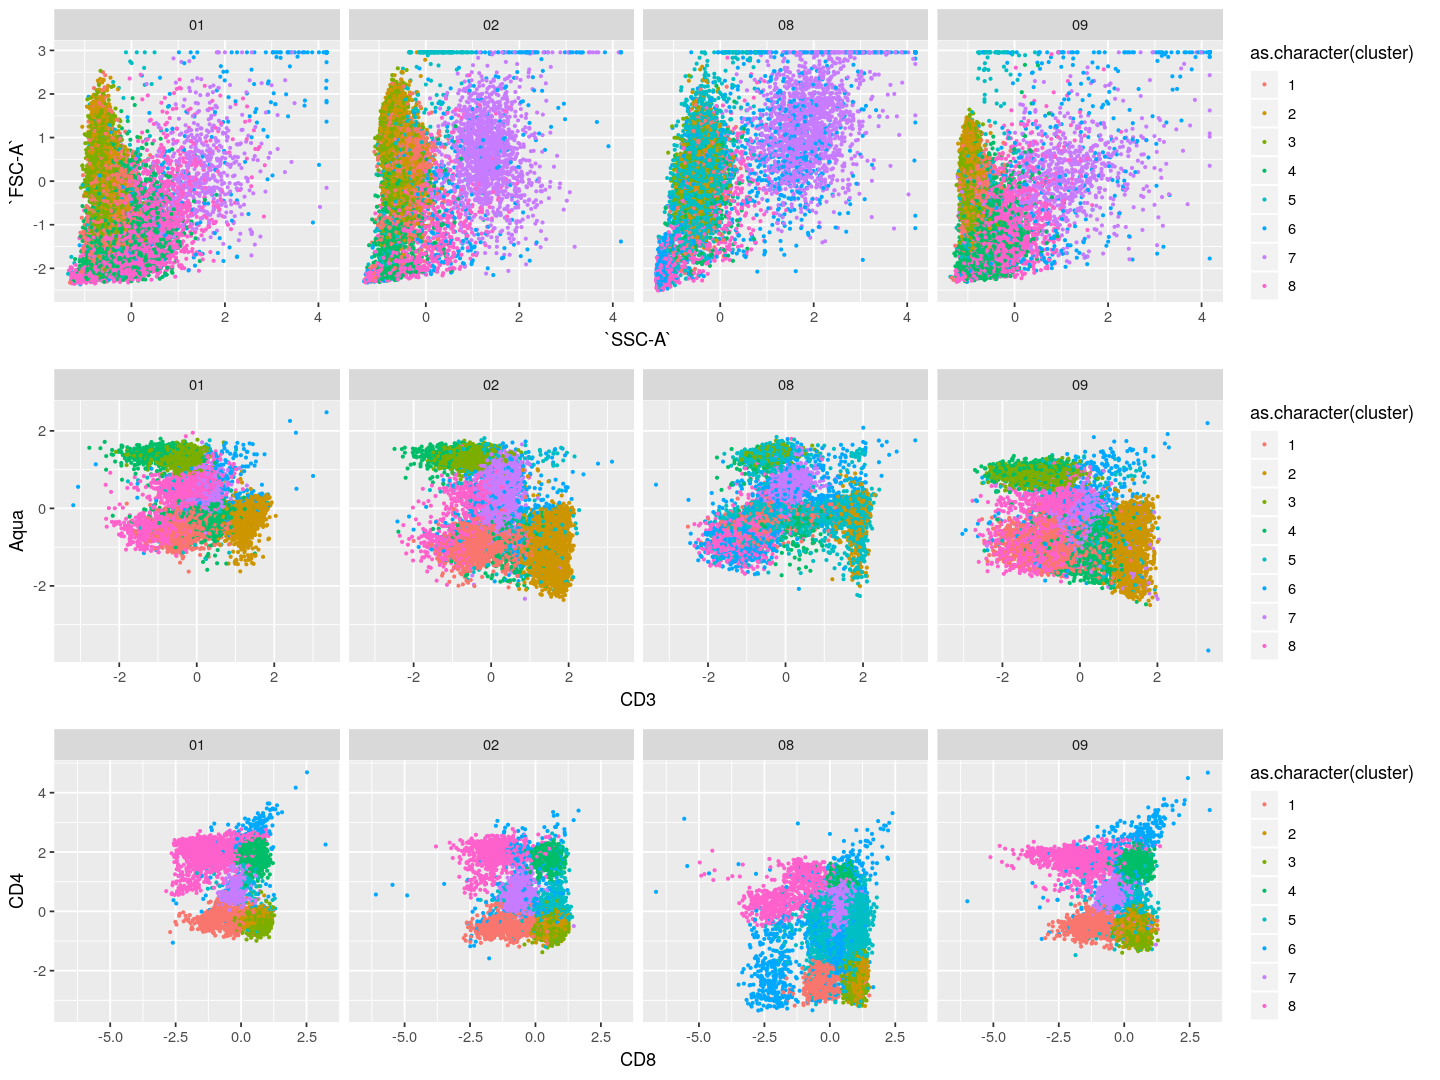

In [75]:
my_cols = brewer.pal(10, "Set3")

dat = dat_mpsk2
dat = dat %>% dplyr::filter(sample %in% c("01", "02", "08", "09"))
mygp = ggplot()

gp1 = ggplot(., aes(x = `SSC-A`, y = `FSC-A`, color = as.character(cluster))) + 
          geom_point(size = 0.5, alpha = ) + 
          facet_wrap(~sample, nrow = 1)
gp2 = dat %>% ggplot(., aes(x = CD3, y = Aqua, color = as.character(cluster))) + 
          geom_point(size = 0.5) + 
          facet_wrap(~sample, nrow = 1)

gp3 = dat %>% ggplot(., aes(x = CD8, y = CD4, color = as.character(cluster))) + 
          geom_point(size = 0.5) + 
          facet_wrap(~sample, nrow = 1)

options(repr.plot.width = 12, repr.plot.height = 9)
gridExtra::grid.arrange(gp1, gp2, gp3)